## 1. Setup & Preprocessing
## Problem Statement

Depression is one of the most prevalent mental health issues worldwide, significantly affecting daily life and well-being. Wearable and smartphone-based sensing provides an opportunity to passively capture behavioral signals such as physical activity, sleep, and mobility. The objective of this study is to analyze longitudinal behavioral data from the **GLOBEM dataset** to understand the relationship between these signals and depression symptoms.

---

## Research Questions
1. Can daily step count and sleep duration patterns help identify signs of depression?
2. Do weekday vs. weekend behavioral patterns differ for individuals with higher depression scores?
3. How accurately can a machine learning model classify depression status using passive sensing features?

---

## Dataset Reference
- **Source:** [The GLOBEM dataset](https://the-globem.github.io)
- **Description:** Collected over four consecutive years (2018–2021) from 497 individuals (~705 person-years).
- **Features:** Step count, sleep duration, and other passive behavioral metrics.
- **Labels:** Weekly depression survey scores (binary outcome: depressed / not depressed).

In [2246]:
#Packages used in exercise
!pip install holidays
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score
import torch
import torch.nn.functional as F
import torch, numpy as np, random
from sklearn.metrics import balanced_accuracy_score

DATA_DIR stores the directory path where the GLOBEM dataset is located.<br>
DATA_SETS is a list of dataset identifiers (INS-W_1 to INS-W_4), each representing different subsets or study waves. <br>
Together, they help the code systematically load and process multiple datasets from the specified location.

In [2247]:
#Data Path
DATA_DIR = '/Volumes/SanDisk/MyData/WALSHAIMl/WalshAIML/Capstone/Depression-Detection/globem-dataset-multi-year-datasets-for-longitudinal-human-behavior-modeling-generalization-1.1/Data/'
DATA_SETS = ['INS-W_1','INS-W_2','INS-W_3','INS-W_4']

In [2248]:
#loaing all data sets
data_yearly = {}
for dataset in DATA_SETS:
    features = pd.read_csv(DATA_DIR+ dataset + '/FeatureData/rapids.csv', low_memory=False, index_col=0)
    labels = pd.read_csv(DATA_DIR+ dataset + '/SurveyData/dep_weekly.csv', low_memory=False, index_col=0)
    data_yearly[dataset] = pd.merge(features, labels[['pid', 'date', 'dep']], on=['pid', 'date'], how='inner')

This function plots a bar chart from a dictionary. It creates a figure, draws bars for each key-value pair, and labels each bar with its value. The chart includes a title, x/y-axis labels, rotated x-ticks for readability, and sky-blue bars with black edges. It ensures a tight layout for display.

In [2249]:
def plot_dictionary_key_value(val_dict, title, xLabel, yLabel):
    # Sort dict by values (largest to smallest)
    #sorted_dict = dict(sorted(val_dict.items(), key=lambda x: x[1], reverse=True))
    fig, ax = plt.subplots(figsize=(5,5))
    bars = ax.bar(val_dict.keys(), val_dict.values(), color="skyblue", edgecolor="black")
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.05,   # position
                f"{int(height)}", ha='center', va='bottom')

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel(xLabel )
    ax.set_ylabel(yLabel )
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [2250]:
#check the columns and row count of datasets.
columns_dict = {}
rows_dict = {}
#all columns (features which have mostly all columns NAN values)
for datasetName, df in data_yearly.items():
    rows, cols = df.shape
    rows_dict[datasetName] = rows
    columns_dict[datasetName] = cols

## Exploratory Data Analysis (EDA)

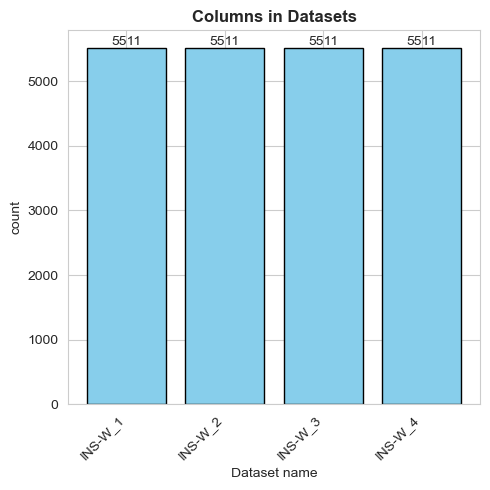

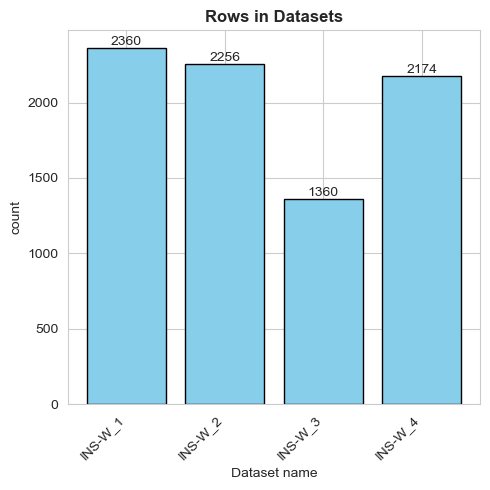

In [2251]:
plot_dictionary_key_value(columns_dict,title="Columns in Datasets", xLabel="Dataset name", yLabel="count")
plot_dictionary_key_value(rows_dict,title="Rows in Datasets", xLabel="Dataset name", yLabel="count")

The code identifies columns with over 90% missing values in each dataset within data_yearly. It replaces infinities with NaN, computes the missing value ratio per column, counts highly missing columns, stores the counts in a dictionary, and visualizes the results with a bar chart using plot_dictionary_key_value()

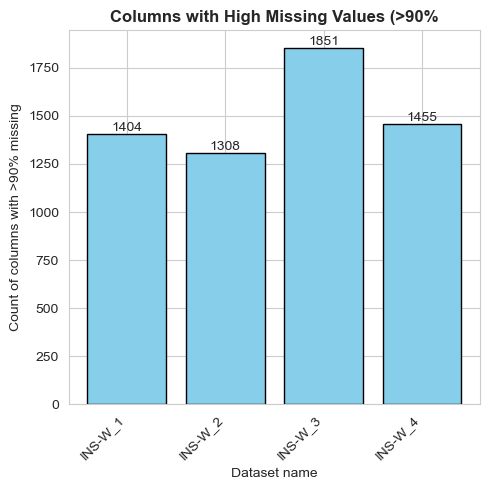

In [2252]:
#find columns of High missing values columns
pd.set_option('future.no_silent_downcasting', True)

NAN_THRESHOLD = 0.9
missing_val_dict = {}
#all columns (features which have mostly all columns NAN values)
for i, (datasetName, df) in enumerate(data_yearly.items()):
    # Calculate percentage of NaN values per column
    df_replaced = df.replace([np.inf, -np.inf], np.nan)
    nan_ratio = df_replaced.isna().mean()
    high_nan = nan_ratio[nan_ratio > NAN_THRESHOLD].sort_values()
    missing_val_dict[datasetName] = high_nan.shape[0]

plot_dictionary_key_value(missing_val_dict, title= f'Columns with High Missing Values (>{NAN_THRESHOLD*100:.0f}%',
                          xLabel="Dataset name", yLabel=f'Count of columns with >{NAN_THRESHOLD*100:.0f}% missing')


In [2253]:
#Remove columns (features which have mostly all columns NAN values)
for i, (datasetName, df) in enumerate(data_yearly.items()):
    # Calculate percentage of NaN values per column
    df_replaced = df.replace([np.inf, -np.inf], np.nan)
    df_cleaned = df.dropna(axis=1, thresh=int((1-NAN_THRESHOLD) * len(df_replaced)))
    print(f"Dataset {datasetName} Original shape:{df.shape} Cleaned shape: {df_cleaned.shape}")
    data_yearly[datasetName] = df_cleaned

Dataset INS-W_1 Original shape:(2360, 5511) Cleaned shape: (2360, 4110)
Dataset INS-W_2 Original shape:(2256, 5511) Cleaned shape: (2256, 4203)
Dataset INS-W_3 Original shape:(1360, 5511) Cleaned shape: (1360, 3660)
Dataset INS-W_4 Original shape:(2174, 5511) Cleaned shape: (2174, 4056)


This code counts duplicate rows in each dataset within data_yearly. For each dataset:
- df.duplicated().sum() calculates the number of rows that are exact duplicates. <br>
- The count is stored in duplicate_rows_dict with the dataset name as the key. <br>

**Result:** a dictionary mapping datasets to their duplicate row counts.

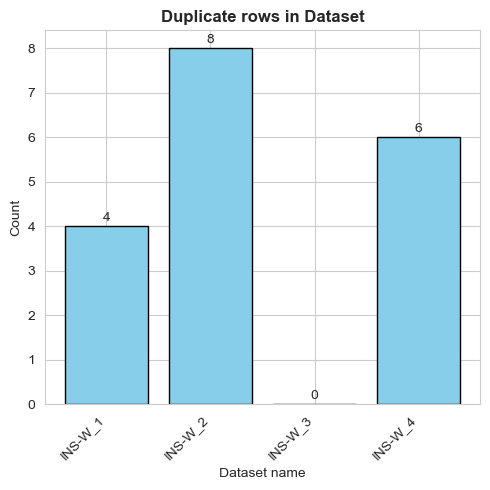

In [2254]:
#Duplicate rows
duplicate_rows_dict = {}
#all columns (features which have mostly all columns NAN values)
for i, (datasetName, df) in enumerate(data_yearly.items()):
    dup_count = df.duplicated().sum()
    duplicate_rows_dict[datasetName] = dup_count

plot_dictionary_key_value(duplicate_rows_dict, title= f'Duplicate rows in Dataset',xLabel="Dataset name", yLabel=f'Count')

This code iterates over each dataset in data_yearly, removes duplicate rows using df.drop_duplicates(), prints the original and cleaned shapes for comparison, and updates the dictionary with the cleaned DataFrame. <br>
It ensures that all datasets are free of duplicate rows while providing a quick summary of the reduction in size.<br>

In [2255]:
#Remove duplication rows from Dataset
for i, (datasetName, df) in enumerate(data_yearly.items()):
    # Remove duplicates
    df_cleaned = df.drop_duplicates()
    print(f"Dataset {datasetName} Original shape:{df.shape} Cleaned shape: {df_cleaned.shape}")
    data_yearly[datasetName] = df_cleaned

Dataset INS-W_1 Original shape:(2360, 4110) Cleaned shape: (2356, 4110)
Dataset INS-W_2 Original shape:(2256, 4203) Cleaned shape: (2248, 4203)
Dataset INS-W_3 Original shape:(1360, 3660) Cleaned shape: (1360, 3660)
Dataset INS-W_4 Original shape:(2174, 4056) Cleaned shape: (2168, 4056)


In [2256]:
#print info of Dataset
for datasetName, df in data_yearly.items():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 0 to 2359
Columns: 4110 entries, pid to dep
dtypes: bool(1), float64(2738), object(1371)
memory usage: 73.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2248 entries, 0 to 2255
Columns: 4203 entries, pid to dep
dtypes: bool(1), float64(2800), object(1402)
memory usage: 72.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Columns: 3660 entries, pid to dep
dtypes: bool(1), float64(2438), object(1221)
memory usage: 38.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2168 entries, 0 to 2173
Columns: 4056 entries, pid to dep
dtypes: bool(1), float64(2702), object(1353)
memory usage: 67.1+ MB
None


In [2257]:
# Type corrections of columns (Date) and covert dep colunm to int
for datasetName, df in data_yearly.items():
    df_clean = df.copy()
    df_clean['date'] = df_clean['date'].astype(str).str.strip()
    df_clean['date'] = pd.to_datetime(df_clean['date'],errors='coerce').astype('datetime64[ns]')
    df_clean['dep'] = pd.to_numeric(df_clean['dep'], errors='coerce').astype('int')
    data_yearly[datasetName] = df_clean

In [2258]:
for datasetName, df in data_yearly.items():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 0 to 2359
Columns: 4110 entries, pid to dep
dtypes: datetime64[ns](1), float64(2738), int64(1), object(1370)
memory usage: 73.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2248 entries, 0 to 2255
Columns: 4203 entries, pid to dep
dtypes: datetime64[ns](1), float64(2800), int64(1), object(1401)
memory usage: 72.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Columns: 3660 entries, pid to dep
dtypes: datetime64[ns](1), float64(2438), int64(1), object(1220)
memory usage: 38.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2168 entries, 0 to 2173
Columns: 4056 entries, pid to dep
dtypes: datetime64[ns](1), float64(2702), int64(1), object(1352)
memory usage: 67.1+ MB
None


These outputs show the structure of four DataFrames. <br>
Each displays the number of rows (entries) and columns, data types (boolean, float64, object), and memory usage.<br>
 The differences indicate varying dataset sizes, feature counts, and memory requirements, reflecting the diversity and scale of the data being handled.

In [2259]:
#Get common columns in Dataset
common_cols = None
for name, df in data_yearly.items():
    if common_cols is None:
        common_cols = set(df.columns)
    else:
        common_cols &= set(df.columns)
print(f'Common features in all dataset len : {len(common_cols)}')

Common features in all dataset len : 3564


This code finds the common columns shared across all datasets in data_yearly.<br>
It initializes common_cols with the first dataset’s columns and iteratively intersects it with each subsequent dataset’s columns using &=.<br>
The result is the set of features present in every dataset, and its length is printed for reference.<br>

In [2260]:
# Collect common features (columns) in DataSets and merge all 4 Data set with common columns.
for i,datasetName in enumerate(DATA_SETS[:4]):
    df = data_yearly[datasetName]
    features_df = df[list(common_cols)]
    data_yearly[datasetName] = features_df

full_df = pd.concat([data_yearly[datasetName] for datasetName in DATA_SETS])
print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8132 entries, 0 to 2173
Columns: 3564 entries, f_loc:phone_locations_doryab_timeattop3location_dis:weekend to f_loc:phone_locations_barnett_wkenddayrtn_dis:7dhist
dtypes: datetime64[ns](1), float64(2374), int64(1), object(1188)
memory usage: 221.2+ MB
None
after merging unique user count 703


This code selects the common columns from the first four datasets in DATA_SETS, updates each dataset to include only these features, and concatenates them into a single full_df.<br>
It then prints the merged DataFrame’s structure and reports the number of unique users based on the pid column.

In [2261]:
#get all featured column. Normalized and hist columns are not needed.
key_cols= ['pid','date','dep']

def get_feature_columns(df):
    # Parse features to normalize (excluding discretized or already normalized)
    feature_cols = [col for col in df.columns if ':' in col
                    and '_norm' not in col
                    and '14dhist' not in col
                    and '_dis' not in col
                    and '7dhist' not in col]
    return feature_cols

In [2262]:
# Reduce the features set taking only features columns. Let's remove others
target_col = 'dep'
features_cols = get_feature_columns(full_df)
features_cols.extend(key_cols)
full_df = full_df[features_cols]
print(f"Full DataFrame shape: {full_df.shape}")
print(f'Count of missing value in Target column is {full_df[target_col].isnull().sum()}')

Full DataFrame shape: (8132, 815)
Count of missing value in Target column is 0
after collecting features unique user count 703


This code refines full_df by keeping only feature columns and key identifiers, excluding irrelevant columns.<br>
It prints the DataFrame’s shape, counts missing values in the target column dep, and reports the number of unique users (pid).<br>
This ensures the dataset is clean and focused for modeling purposes.

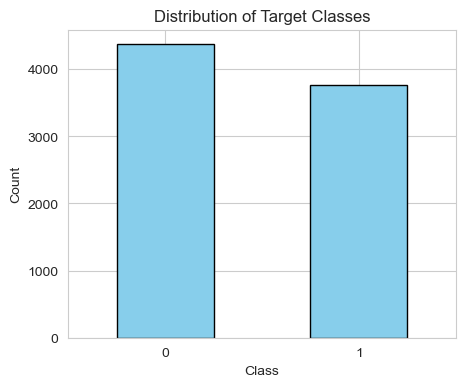

In [2263]:
value_counts = full_df[target_col].value_counts()
plt.figure(figsize=(5,4))
value_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Target Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

This code visualizes the distribution of classes in the target column dep.<br>
It counts occurrences of each class with value_counts(), creates a bar chart with sky-blue bars and black edges, sets axis labels and title, and ensures class labels are horizontal.<br>
The plot highlights class imbalance visually.

/var/folders/p2/zd8t6_xx1hg9y7vlvjtwfbbc0000gn/T/ipykernel_1730/3177689679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df_target['year'] = pd.to_datetime(full_df_target['date']).dt.year


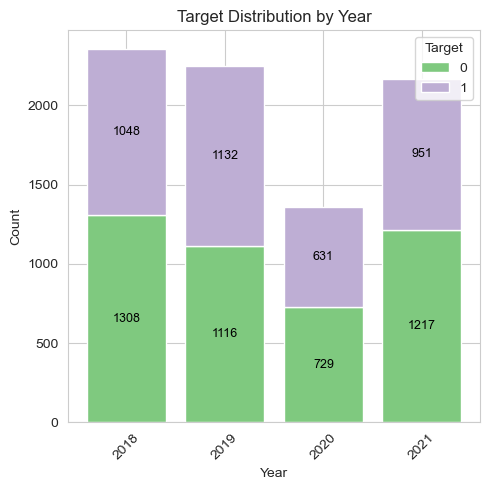

In [2264]:
full_df_target = full_df[['date',target_col]]
full_df_target['year'] = pd.to_datetime(full_df_target['date']).dt.year

counts = full_df_target.groupby(["year", target_col]).size().unstack(fill_value=0)

# Plot stacked bar
fig, ax = plt.subplots(figsize=(5,5))
bottom = np.zeros(len(counts))

colors = plt.cm.Accent.colors  # color map
for i, col in enumerate(counts.columns):
    ax.bar(counts.index, counts[col], bottom=bottom, color=colors[i % len(colors)], label=col)
    # Add count labels on each segment
    for x, y, b in zip(counts.index, counts[col], bottom):
        if y > 0:
            ax.text(x, b + y/2, str(y), ha='center', va='center', fontsize=9, color='black')

    bottom += counts[col].values

ax.set_title("Target Distribution by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.legend(title="Target")

# x-axis: show integer years
ax.set_xticks(counts.index)                # set tick positions
ax.set_xticklabels([int(x) for x in counts.index], rotation=45)  # set tick labels as integers
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This code visualizes the yearly distribution of target classes.<br>
It extracts year from date, groups by year and dep, and counts occurrences.<br>
A stacked bar chart shows each class per year with labels, custom colors, integer x-ticks, and a legend, providing a clear overview of temporal class trends.<br>

================================================================================================

The stacked bar chart may mask class imbalance because each year’s total is stacked, making smaller classes visually less noticeable.<br>
The bars show absolute counts per class stacked together, so differences between dominant and minor classes are hard to perceive, especially if one class vastly outweighs others.

In [2265]:
users_ids = ['INS-W_004',
               'INS-W_302',
               'INS-W_603',
               'INS-W_1003']
step_col = 'f_steps:fitbit_steps_summary_rapids_avgsumsteps:allday'

def line_plot_steps_summary(full_dataset, users_dataset):
    fig, ax = plt.subplots(2,2,figsize=(10,6))
    ax = ax.flatten()
    for i,user_id in enumerate(users_dataset):
        steps_df = full_dataset[['pid','date',step_col,'dep']].copy()
        # Ensure proper datetime format
        steps_df['date'] = pd.to_datetime(steps_df['date'])
        steps_df_user = steps_df[steps_df['pid'] == user_id]
        ax[i].plot(steps_df_user['date'], steps_df_user[step_col], marker='o', linestyle='-', label='Daily Steps')
        # If depression scores are available, overlay them
        if 'dep' in steps_df_user.columns:
            depressed_days = steps_df_user[steps_df_user['dep'] == True]  # threshold example
            ax[i].scatter(depressed_days['date'], depressed_days[step_col],
                    color='red', label='Depression', zorder=5, marker='x',s=100)
        # Set labels and title
        ax[i].set_xlabel("Date")
        ax[i].set_ylabel("Step Count")
        ax[i].set_title(f"Daily Step Count Over Time - User {user_id}")
        ax[i].tick_params(axis='x', rotation=45)
        # Show legend and grid
        ax[i].legend()
        ax[i].grid(True)
    plt.tight_layout()
    plt.show()

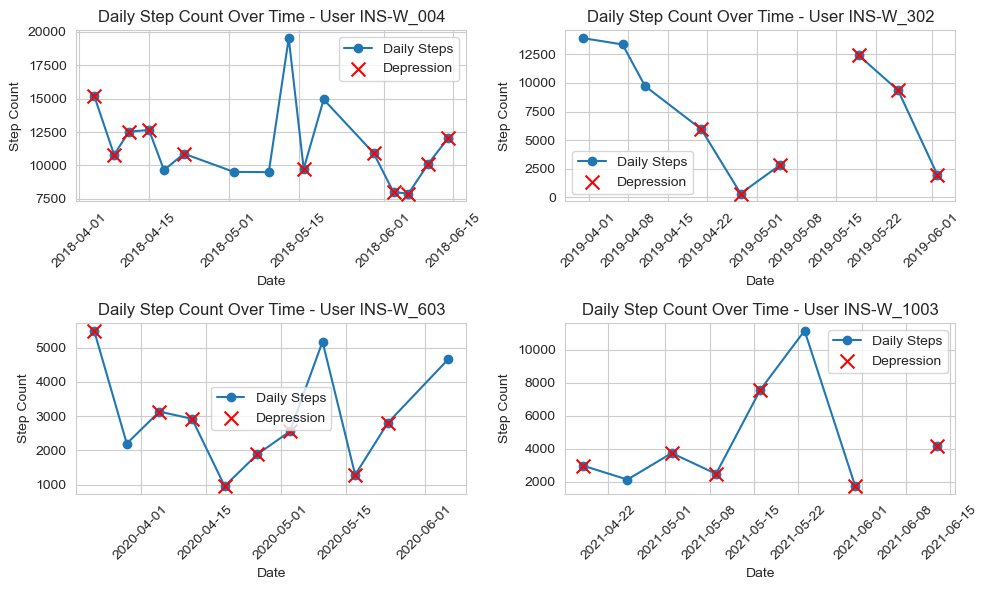

In [2266]:
line_plot_steps_summary(full_df, users_ids)

**Overall Insights**
- **Low activity correlates with depression** — most users show depressive days around reduced step counts.<br>
- **Patterns differ across individuals** — some show depression at moderate activity too, indicating personal baselines matter.
- **Behavioral variability** (sudden drops, inconsistent step counts) may also signal mental health changes.
- This supports the idea that wearable activity data can serve as digital biomarkers for depression monitoring.

In [2267]:
def applyLabelEncoder(df):
    obj_cols = df.select_dtypes(include='object')
    for col in obj_cols.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(obj_cols[col].astype(str))
    return df

def replace_NAN(df, val=0):
    df_clean = df.replace([np.inf, -np.inf], np.nan)  # replace Inf
    numeric_cols = df_clean.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')  # convert what can be numeric
        df_clean = df_clean.fillna(val)  # fill NaNs
    return df_clean

def apply_Min_Max_scaler(df,skip_cols=[]):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    result = [item for item in numeric_cols if item not in skip_cols]
    df[result] = MinMaxScaler().fit_transform(df[result])
    return df

def replace_outliers_per_user(df, user_col='pid', feature_cols=[]):
    for col in feature_cols:
        # Step 2: Replace outliers with median per user
        def replace_outliers(x):
            q1 = x.quantile(0.25)
            q3 = x.quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            mean = x.mean()
            return x.where((x >= lower) & (x <= upper), mean)
        df[col] = df.groupby(user_col)[col].transform(replace_outliers)
    return df

## Normalize Features (Per User)

User-level normalization is the process of transforming each user’s time-series data relative to their own historical baseline, not the entire dataset.

#### Motivation:
- Different users have different natural behaviors.
- One person might sleep 9 hours, another 6 hours — both are normal for them.
- Applying global normalization would treat this variance as noise.
- Goal: Detect deviations from personal norms, not population norms.

In [ ]:
def normalize_per_user(df, user_col='pid', feature_cols=[]):
    df = df.copy()
    for col in feature_cols:
        df[col] = df.groupby(user_col)[col].transform(
            lambda x: (x - x.median()) / (x.quantile(0.95) - x.quantile(0.05) + 1e-6)
        )
    return df

This code performs a data cleaning and preprocessing pipeline on full_df.<br>
The replace_NAN function replaces all NaN or infinite values with zeros, ensuring no missing data.<br>
Next, applyLabelEncoder converts categorical/object columns into numeric labels suitable for modeling, and the unique user count is printed to verify consistency. <br>
Then, normalize_per_user standardizes the feature columns for each user individually, removing scale differences while maintaining user-specific patterns.<br>
Finally, it prints the DataFrame info and confirms the number of unique users remains unchanged after encoding and normalization, ensuring data integrity.<br>

In [2268]:
print(f'before replacing nan unique user count {full_df['pid'].nunique()}')
#Remove NAN values from entire dataset. Replacing them with zero values.
full_df = replace_NAN(full_df)
print(f'After replacing nan unique user count {full_df['pid'].nunique()}')

#Apply Label encoding on data set
full_df = applyLabelEncoder(full_df)
print(f'After Label Encoder unique user count {full_df['pid'].nunique()}')

#Normalized data set per user
features_cols = get_feature_columns(full_df)
full_df = normalize_per_user(full_df, feature_cols=features_cols)
print(full_df.info())
print(f'After Normalizing Encoder unique user count {full_df['pid'].nunique()}')

before replacing nan unique user count 703
After replacing nan unique user count 703
After Label Encoder unique user count 703
<class 'pandas.core.frame.DataFrame'>
Index: 8132 entries, 0 to 2173
Columns: 815 entries, f_blue:phone_bluetooth_doryab_countscansleastfrequentdevicewithinsegmentsall:weekend to dep
dtypes: datetime64[ns](1), float64(812), int64(2)
memory usage: 50.6 MB
None
After Normalizing Encoder unique user count 703


In [2269]:
#This function identifies the most important features for predicting the target dep using a Random Forest classifier. It encodes categorical targets, fits the model, computes feature importances, selects the top k features, and creates a horizontal bar plot of the top 10 features. It returns the top feature list and the plot object.

def get_ImportantFeatures(df,xColumns,yColumn='dep',top_k=50):
    X = df[xColumns]
    y = df[yColumn]
    if y.dtypes == "object":
        y = LabelEncoder().fit_transform(y)

    rf = RandomForestClassifier(n_estimators=200, random_state=42,
                                max_depth=8, min_samples_leaf=5, max_features='sqrt',class_weight='balanced')
    rf.fit(X, y)
    importances = rf.feature_importances_
    feature_names = X.columns
    # Create a DataFrame for easy viewing
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_k)
    top_features = importance_df["Feature"].tolist()
    importance_df = importance_df.head(10 if top_k > 10 else top_k)
    # Draw a single plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance',y='Feature',data=importance_df,color='lightblue')
    # Titles and labels
    plt.title("Feature Importance for Depression Prediction", fontsize=14)
    plt.ylabel("Feature")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    return top_features, plt

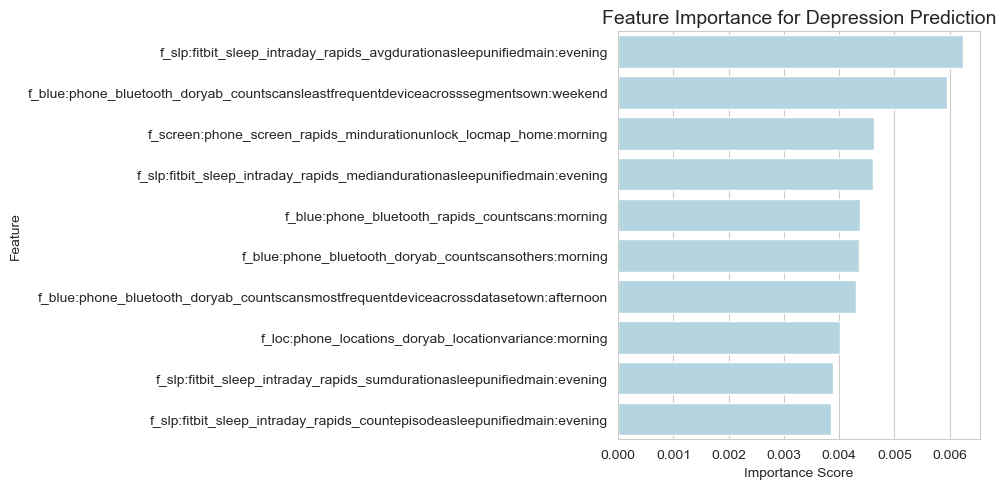

In [2270]:
features_cols = [x for x in full_df.columns if x not in key_cols]
top_features, plt = get_ImportantFeatures(full_df, features_cols, top_k=100)
plt.show()

In your Random Forest feature importance analysis, the highest importance score is only 0.006, indicating that no single feature dominates in predicting the target dep; the contributions of individual features are relatively small and distributed across many variables.<br>
To capture more predictive information, it is sensible to increase the number of selected features.<br>
Instead of limiting to the top 10 or 50, you can choose the top 100 features based on their importance scores.<br>
This ensures that the model has access to a broader set of moderately important features, which can improve predictive performance while still reducing dimensionality compared to the full feature set.

In [2271]:
feature_cols = get_feature_columns(full_df)
full_df = replace_outliers_per_user(full_df, user_col='pid', feature_cols=feature_cols)
print(f'After replacing outliers unique user count {full_df['pid'].nunique()}')

After replacing outliers unique user count 703


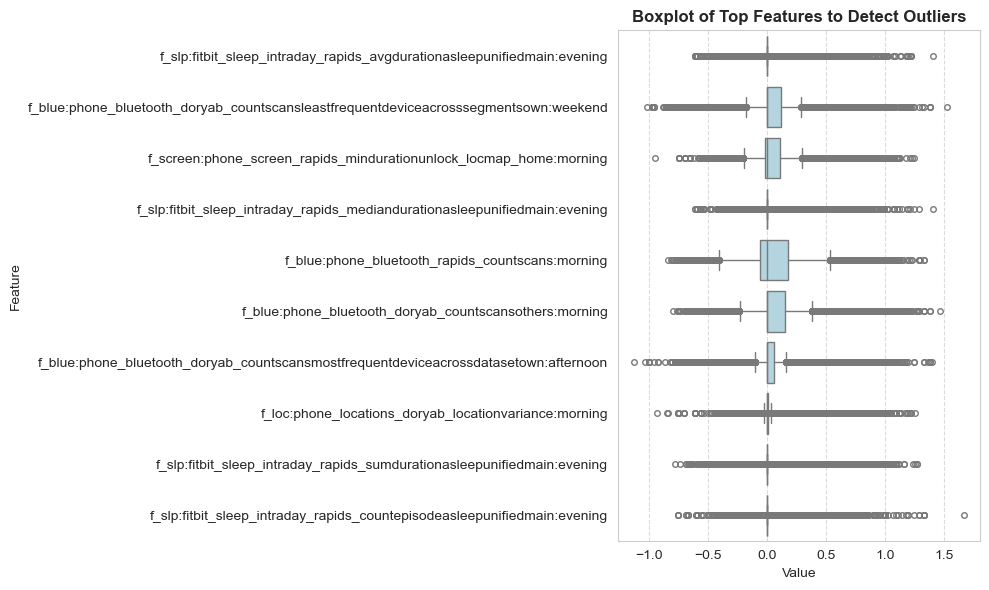

In [2272]:
#This code visualizes outliers in the top 10 features. It reshapes the data with melt for plotting, creates a horizontal boxplot with light-blue color, and sets titles, axis labels, and a grid for clarity. The plot highlights the distribution and extreme values of each feature for inspection.

# Select numeric columns
top10= top_features[:10]
top10Df = full_df[top10]
df_melted = top10Df.melt(var_name='Feature', value_name='Value')
plt.figure(figsize=(10,6))
#df_melted['Feature'] = df_melted['Feature'].str.slice(0, 50)
# Horizontal boxplot
sns.boxplot(y='Feature', x='Value', data=df_melted, orient='h', fliersize=4, color='lightblue')
plt.title("Boxplot of Top Features to Detect Outliers", fontweight='bold')
plt.xlabel("Value")
plt.ylabel("Feature")

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The horizontal boxplot of the top 10 features clearly shows the presence of outliers, indicated by points lying beyond the whiskers of each box.<br>
Outliers can distort model training, especially for algorithms sensitive to feature scale or variance, like linear models.<br>
Random Forests are more robust, but extreme values may still impact performance and importance ranking.<br>

**Next actions:**
- Winsorization – cap extreme values at a chosen percentile (e.g., 1st and 99th).
- Scaling/Normalization – standardize features post-transformation.
- Model evaluation – retrain after handling outliers to compare performance.

This systematic approach ensures cleaner inputs and potentially better predictive results.

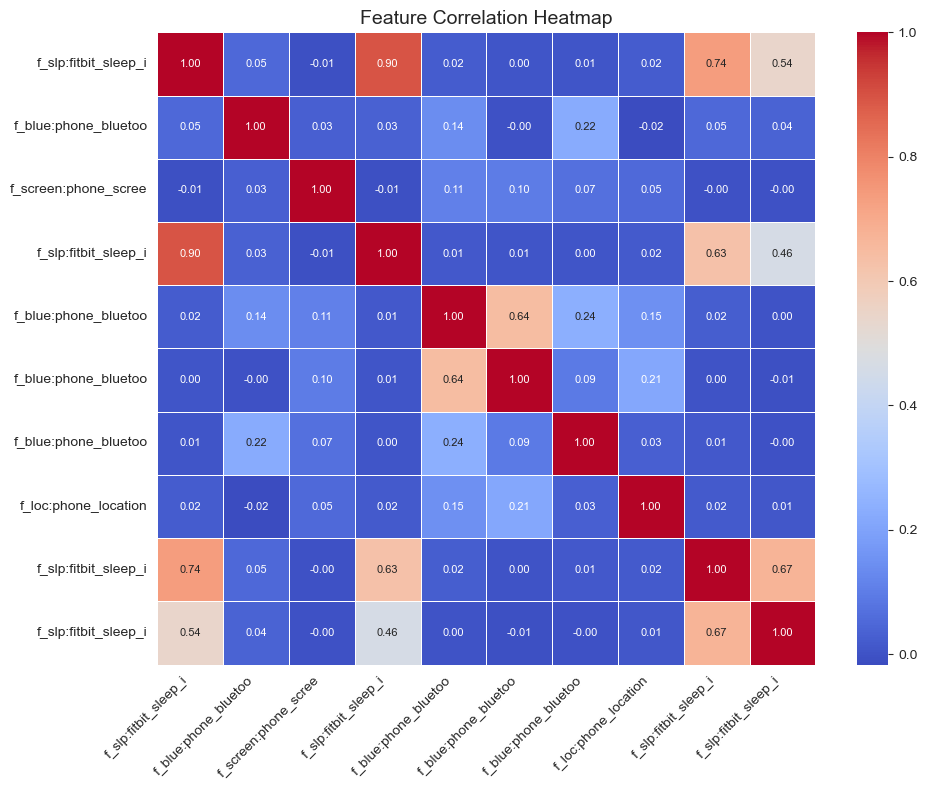

In [2273]:
def draw_heatmap(corr_matrix):
    # Truncate labels to 15 characters
    short_labels = [col[:20] for col in corr_matrix.columns]
    corr_matrix.columns = short_labels
    corr_matrix.index = short_labels

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix,
                annot=True,       # show numbers
                fmt=".2f",        # 2 decimal places
                cmap="coolwarm",
                cbar=True,
                linewidths=0.5,
                annot_kws={"size": 8})  # smaller text for numbers

    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Compute correlation matrix
corr_matrix = full_df[top10].corr(numeric_only=True)
draw_heatmap(corr_matrix)

Creating a correlation heatmap of the top 10 features reveals the pairwise relationships between them.<br>
The values range from -0.1 to 0.9, indicating generally low to moderate correlations.<br>
No extremely high correlations (>0.9) are observed, which suggests minimal multicollinearity, allowing most features to contribute unique information to the model.<br>

Insight: Features are fairly independent, reducing redundancy and overfitting risk. However, some moderate correlations (around 0.7–0.9) might still influence model behavior.

**Next actions:**
- Consider removing or combining moderately correlated features if dimensionality reduction is desired.
- Apply PCA or feature selection to retain only the most informative variables.
- Retrain the model and check performance.

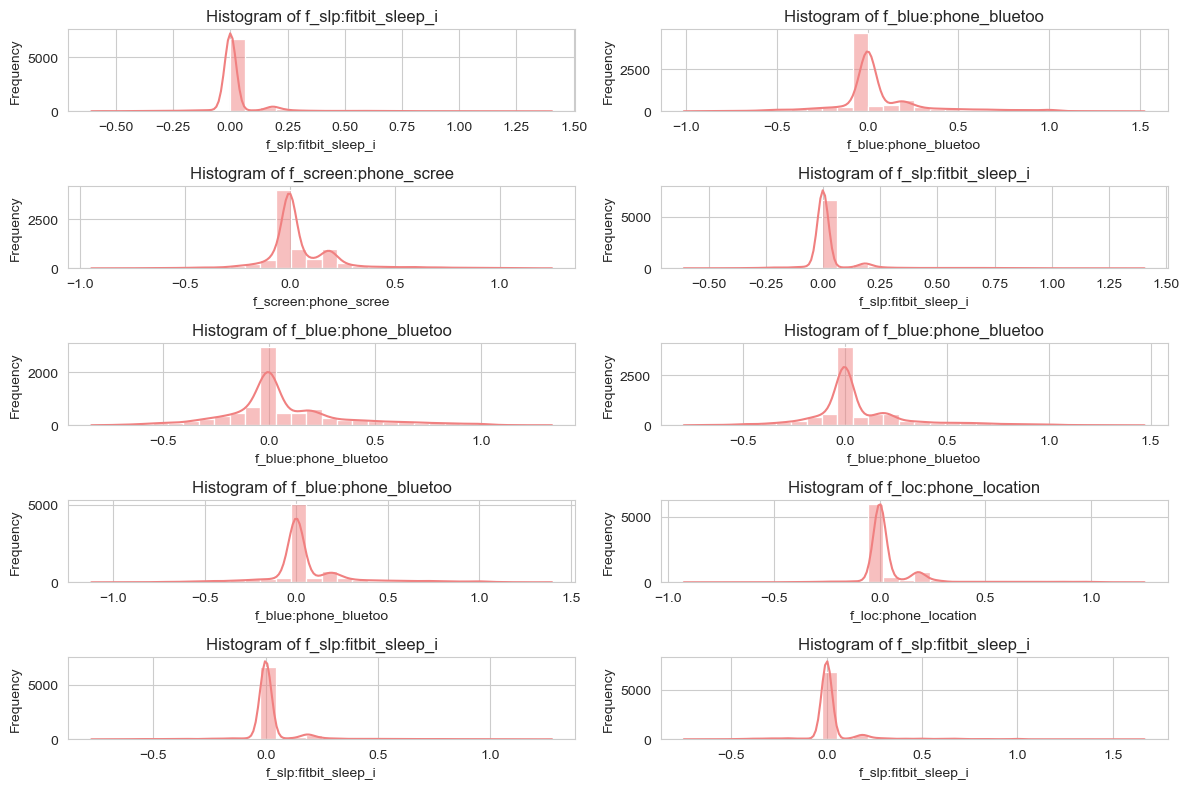

In [2274]:
numeric_cols = full_df[top10].select_dtypes(include=['number']).columns
fig, ax = plt.subplots(5,2,figsize=(12,8))
ax = ax.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(full_df[col], bins=30, kde=True, color="lightcoral", ax=ax[i])
    ax[i].set_title(f"Histogram of {col[:20]}")
    ax[i].set_xlabel(col[:20])
    ax[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

The histograms show the distribution of multiple numerical features (e.g., sleep, Bluetooth usage, screen activity, location).<br>
**Key insights:**
- Most features are heavily skewed toward zero, suggesting sparse activity or low event counts for many users.
- Some features exhibit long right tails, indicating occasional high usage or extreme values.
- Overlapping plots (repeated features) suggest redundancy or multiple instances of the same variable.
- KDE lines highlight density peaks near zero, confirming that the majority of observations are clustered at low values.

**Next actions:** consider outlier handling, feature scaling, and dimensionality reduction to mitigate skewness and redundancy.

In [2275]:
def winsorize_df(df, cols, lower=0.05, upper=0.05):
    df_wins = df.copy()
    for col in cols:
        df_wins[col] = winsorize(df[col], limits=[lower, upper])
    return df_wins

In [2276]:
numeric_cols = full_df.select_dtypes(include=[np.number]).columns
full_df = winsorize_df(full_df, numeric_cols, lower=0.05, upper=0.05)

In [2277]:
top_features.extend(key_cols)
full_df = full_df[top_features]

In [2278]:
full_df.to_csv("clean_data.csv", index=False)
full_df = pd.read_csv("clean_data.csv")

This code performs PCA to reduce dimensionality while retaining 95% of the variance.<br>
First, it standardizes the feature columns, then applies PCA. The original DataFrame is transformed into a smaller set of principal components (df_pca).<br>
Finally, the code merges these PCA features with the key columns (pid and dep) to maintain identifiers and labels for analysis.<br>

In [2279]:
VARIANCE = 0.95
feature_cols = get_feature_columns(full_df)

X = full_df[feature_cols]
y = full_df['dep']
# Keep 95% variance
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=VARIANCE)
X_pca = pca.fit_transform(X)

print("Original shape:", full_df.shape)

# Create new DataFrame with PCA features
df_pca = pd.DataFrame(
    X_pca,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

print("Reduced shape:", df_pca.shape)

# Add back pid + label
full_df = pd.concat(
    [df_pca.reset_index(drop=True), full_df[key_cols].reset_index(drop=True)],
    axis=1
)

Original shape: (8132, 103)
Reduced shape: (8132, 68)


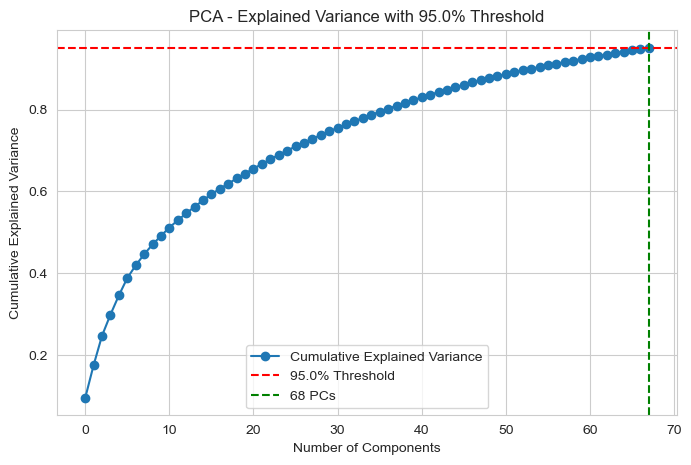

Number of components to reach 95.0% variance: 68


In [2280]:
plt.figure(figsize=(8,5))
# Cumulative explained variance
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_var, marker='o', label="Cumulative Explained Variance")
plt.axhline(y=VARIANCE, color='r', linestyle='--', label=f'{VARIANCE*100}% Threshold')  # 95% line

# Find number of components where we cross threshold %
n_components_9X = np.argmax(cumulative_var >= VARIANCE) + 1
plt.axvline(x=n_components_9X-1, color='g', linestyle='--', label=f'{n_components_9X} PCs')

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title(f"PCA - Explained Variance with {VARIANCE*100}% Threshold")
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of components to reach {VARIANCE*100}% variance: {n_components_9X}")

After applying PCA, 68 principal components are required to capture 95% of the dataset’s variance.<br>
This means that these 68 components effectively summarize the information from the original, higher-dimensional feature set, reducing complexity while retaining most of the important patterns for modeling or analysis.

A rolling window is a technique where you take overlapping fixed-size segments from a time-series to analyze local temporal patterns.

We are working with daily passive behavioral data for each user. Instead of modeling entire time-series as a whole:
- Extract small chunks (e.g., 7 days at a time)
- Move the window forward day-by-day (or by custom steps)
- Label each window with a mood score (e.g., PHQ-4) on the last day

Sequential windows of user data constructs contextual features for each window.<br>
It considers holiday effects using the country-specific holiday calendar, weekend patterns (Saturday/Sunday), and a defined COVID period (March 2020–December 2021).<br>
For each window, weekday indicators are encoded as dummy variables, averaged to capture weekly patterns, while the mean of the raw features, weekend flag, holiday flag, and COVID flag are combined into a single context vector.
These context vectors summarize temporal, seasonal, and pandemic-related influences per user, providing enriched information for modeling, alongside windowed feature sequences and the user-level depression label. <br>

In [2281]:
# ========================================
# 1. Rolling window creation per user
# ========================================
def create_user_windows(full_df, feature_cols, window_size=7, step_size=1, country="US"):
    windows_by_user = {}
    context_by_user = {}
    dep_by_user = {}
    # load holidays
    holiday_calendar = holidays.country_holidays(country)

    for pid, user_df in full_df.groupby("pid"):
        user_df = user_df.sort_values("date")
        sel_features = user_df[feature_cols].values
        dates = pd.to_datetime(user_df["date"]).values

        windows = []
        contexts = []

        for start in range(0, len(sel_features) - window_size + 1, step_size):
            window_feats = sel_features[start:start + window_size]
            window_dates = dates[start:start + window_size]

            # --- Context features ---
            weekday_flags = [pd.Timestamp(d).weekday() for d in window_dates]   # 0=Mon..6=Sun
            is_weekend = [1 if w >= 5 else 0 for w in weekday_flags]            # Sat=5, Sun=6
            is_holiday = [1 if pd.Timestamp(d) in holiday_calendar else 0 for d in window_dates]

            # COVID period: example Mar 2020 - Dec 2021
            is_covid = [
                1 if (pd.Timestamp(d) >= pd.Timestamp("2020-03-01")) &
                     (pd.Timestamp(d) <= pd.Timestamp("2021-12-31")) else 0
                for d in window_dates
            ]
            # Fix: always 7-length weekday vector
            weekday_dummies = pd.get_dummies(weekday_flags)
            weekday_dummies = weekday_dummies.reindex(columns=range(7), fill_value=0)
            weekday_vec = weekday_dummies.mean(axis=0).values

            context_vec = np.concatenate([
                window_feats.mean(axis=0),
                [np.mean(is_weekend)],
                [np.mean(is_holiday)],
                [np.mean(is_covid)],
                weekday_vec
            ])
            windows.append(window_feats)
            contexts.append(context_vec)

        if len(windows) == 0:
            continue

        windows_by_user[pid] = windows
        # Take mean across windows for "user-level" context
        context_by_user[pid] = np.mean(contexts, axis=0)

        # Depression label if available
        if 'dep' in df.columns:
            dep_by_user[pid] = user_df['dep'].iloc[0]
        else:
            dep_by_user[pid] = -1

    return windows_by_user, context_by_user, dep_by_user


## Hierarchical Temporal Contrastive Learning (HTCL)
**Hierarchical Temporal Contrastive Learning (HTCL)** is a deep learning framework designed to learn robust and personalized representations of sequential (temporal) data — particularly for behavioral modeling tasks like depression detection from smartphone-based passive sensing.

Hierarchical Temporal Contrastive Learning is a learning paradigm that uses contrastive loss at multiple temporal resolutions (hierarchies) to train models to differentiate between:
- Semantically similar sequences (e.g., the same user under similar mental states) and
- Semantically different sequences (e.g., different users or opposite mental states),
<br>
in order to learn temporally-aware, user-sensitive embeddings for downstream tasks like classification or regression.

**Key Concepts** <br>
1. Contrastive Learning
- Learns by comparing triplets: (anchor, positive, negative)
- Goal: bring anchor ↔ positive closer in latent space, and push anchor ↔ negative further apart
- Used without explicit supervision (e.g., PHQ scores may not be needed during representation learning)
2. Temporal
- Input data is sequential, e.g., 7-day behavior windows
- Patterns like sleep, activity, and phone usage evolve over time
- Model learns from temporal dependencies
3. Hierarchical
Learns from multiple temporal levels:
- Short-term windows: daily or weekly patterns
- Long-term context: across months or individuals
- Contrastive objectives are applied at different levels:
    - Intra-user contrast: different time windows of the same user
    - Inter-user contrast: compare across different users


In [2282]:
def map_pid(df):
    # Map pid -> contiguous index
    unique_pids = sorted(df['pid'].unique())
    pid2idx = {pid: idx for idx, pid in enumerate(unique_pids)}
    idx2pid = {idx: pid for pid, idx in pid2idx.items()}
    num_users = len(unique_pids)
    return pid2idx, idx2pid, num_users

# ========================================
# 2. Triplet Dataset
# ========================================
def sample_triplet(windows_by_user, pid):
    anchor = random.choice(windows_by_user[pid])
    positive = random.choice(windows_by_user[pid])
    neg_pid = random.choice([p for p in windows_by_user.keys() if p != pid])
    negative = random.choice(windows_by_user[neg_pid])
    return anchor, positive, negative

class TripletDatasetWithContext(Dataset):
    def __init__(self,windows_by_user, context_by_user, labels_by_user=None,pid2idx = None):
        self.windows_by_user = windows_by_user
        self.context_by_user = context_by_user
        self.labels_by_user = labels_by_user
        self.user_ids = list(windows_by_user.keys())
        self.pid2idx = pid2idx

    def __len__(self):
        return sum(len(v) for v in self.windows_by_user.values())

    def __getitem__(self, idx):
        pid = random.choice(self.user_ids)
        anchor, pos, neg = sample_triplet(self.windows_by_user, pid)
        context = self.context_by_user[pid]
        label = self.labels_by_user[pid] if self.labels_by_user is not None else -1
        user_idx = self.pid2idx[pid]  # mapped index for ModuleList
        return (
            torch.tensor(anchor, dtype=torch.float32).transpose(0,1),
            torch.tensor(pos, dtype=torch.float32).transpose(0,1),
            torch.tensor(neg, dtype=torch.float32).transpose(0,1),
            torch.tensor(context, dtype=torch.float32),
            torch.tensor(user_idx, dtype=torch.long) ,
            torch.tensor(label, dtype=torch.long)
        )

In [2283]:
# ========================================
# 3. Temporal Encoder
# ========================================
#The TemporalEncoder class is a PyTorch neural network module designed to extract temporal patterns from sequential data.
# It uses 1D convolutional layers (Conv1d) to capture local dependencies across time steps, each followed by ReLU activations for non-linearity.
# Padding ensures sequence length preservation. An AdaptiveAvgPool1d layer reduces the temporal dimension to a fixed size, summarizing the sequence into a single vector.
# Finally, a fully connected layer projects this representation into a higher-dimensional embedding (out_dim).
# The forward method outputs an L2-normalized vector, which is useful for contrastive learning or downstream tasks requiring comparable temporal embeddings.

class TemporalEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dim=64, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, hidden_dim, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        h = self.conv(x).squeeze(-1)
        return F.normalize(self.fc(h), dim=-1)

In [2284]:
# ========================================
# 4. Personalized Adapter with Context
# ========================================
#The PersonalizedAdapterWithContext module implements user-specific adaptation in a neural network.
# Each user has a small feedforward “adapter” network (a bottleneck layer with ReLU non-linearity followed by a linear projection) that adjusts the shared embedding to better fit their personal patterns.
# During forward propagation, the module selects the adapter corresponding to each user ID and transforms the input embedding accordingly.
# This allows the model to learn personalized representations while keeping most parameters shared, efficiently capturing individual differences.
# It’s particularly useful in sequential or temporal models where context and personal behavior patterns vary across users.

class PersonalizedAdapterWithContext(nn.Module):
    def __init__(self, num_users, embedding_dim, bottleneck=32):
        super().__init__()
        self.adapters = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embedding_dim, bottleneck),
                nn.ReLU(),
                nn.Linear(bottleneck, embedding_dim)
            ) for _ in range(num_users)
        ])

    def forward(self, x, user_ids):
        out = []
        for i, uid in enumerate(user_ids):
            adapter = self.adapters[uid]
            out.append(adapter(x[i]))
        return torch.stack(out, dim=0)

In [2285]:
# ========================================
# 5. Depression Model
# ========================================
# The DepressionDetectionModelWithContext integrates temporal embeddings, contextual features, and personalized adapters.
# The encoder extracts sequence patterns, while the context network processes user-specific information (e.g., holidays, weekends, COVID).
# Combined embeddings are personalized per user via adapters, followed by dropout and fully connected layers to predict depression classes, enabling context-aware, individualized detection.

class DepressionDetectionModelWithContext(nn.Module):
    def __init__(self, encoder, num_users, context_dim, num_classes=2,dropout=0.2 ,freeze_encoder=True):
        super().__init__()
        self.encoder = encoder
        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

        self.context_fc = nn.Sequential(
            nn.Linear(context_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )

        self.adapter = PersonalizedAdapterWithContext(num_users=num_users, embedding_dim=128+32, bottleneck=32)

        self.fc = nn.Sequential(
            nn.Linear(128+32, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, num_classes)
        )
        self.dropout = nn.Dropout(dropout)


    def forward(self, x, context, user_ids):
        h = self.encoder(x)
        c = self.context_fc(context)
        combined = torch.cat([h, c], dim=1)
        h_adapted = self.adapter(combined, user_ids)
        h_adapted = self.dropout(h_adapted)
        return self.fc(h_adapted)

In [2286]:
# ========================================
# 6. Triplet Pretraining
# ========================================
# This train_triplet function trains the temporal encoder using triplet loss to learn meaningful embeddings.
# For each batch, it processes anchor, positive, and negative sequences, computing the triplet margin loss to pull similar samples closer and push dissimilar ones apart.
# The optimizer updates encoder weights over multiple epochs, producing discriminative embeddings.

def train_triplet(encoder, dataloader, device, epochs=5, lr=1e-3):
    encoder.to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
    triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

    for epoch in range(epochs):
        encoder.train()
        total_loss = 0
        for anchor, pos, neg, _, _, _ in dataloader:
            anchor, pos, neg = anchor.to(device), pos.to(device), neg.to(device)
            z_anchor = encoder(anchor)
            z_pos = encoder(pos)
            z_neg = encoder(neg)
            loss = triplet_loss(z_anchor, z_pos, z_neg)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Triplet Epoch {epoch+1}/{epochs} | Loss={total_loss/len(dataloader):.4f}")
    return encoder

In [2287]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [2288]:
# ========================================
# 7. Supervised training with early stopping
# ========================================
# The train_supervised function trains the depression detection model using labeled data with class imbalance handling.
# It first computes class weights to balance the cross-entropy loss for depression vs. non-depression samples. During each epoch, the model processes training batches, computes loss, backpropagates gradients, and updates weights with Adam optimizer.
# Validation is performed per epoch, calculating both the average loss and weighted F1-score.
# Predictions are converted to integer labels for metric computation.
# Early stopping monitors validation loss, saving the best model and stopping training if performance does not improve for a specified patience, preventing overfitting and ensuring generalization.

from sklearn.utils.class_weight import compute_class_weight
def train_supervised(model, dataloader_train, dataloader_val, device, epochs=50, lr=1e-3, patience=10):
    # Compute class weights
    train_labels = []

    for _, _, _, _, _, y in dataloader_train:
        train_labels.extend(y.cpu().numpy().flatten())

    class_weights = compute_class_weight('balanced', classes=np.array([0,1]), y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, _, _, context, user_ids, y in dataloader_train:
            x = x.to(device)
            context = context.to(device)
            user_ids = user_ids.to(device)
            y = y.to(device)
            preds = model(x, context, user_ids)
            loss = criterion(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(dataloader_train)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for x, _, _, context, user_ids, y in dataloader_val:
                x = x.to(device)
                context = context.to(device)
                user_ids = user_ids.to(device)
                y = y.to(device)
                preds = model(x, context, user_ids)
                loss = criterion(preds, y)
                val_loss += loss.item()
                predslabels = torch.argmax(preds, dim=1).cpu().numpy()
                ylabel = y.cpu().numpy().astype(int)  # ensure int labels
                all_preds.extend(predslabels)
                all_labels.extend(ylabel)
        avg_f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_val_loss = val_loss / len(dataloader_val)
        print(f"Epoch {epoch+1} | f1 score {avg_f1:.2f} | Train Loss={avg_train_loss:.2f} | Val Loss={avg_val_loss:.2f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

In [2289]:
# ========================================
# 8. Evaluation
# ========================================
# The evaluate_model function assesses the performance of the trained depression detection model.
# It sets the model to evaluation mode, disables gradient computation, and iterates over the test or validation dataset.
# For each batch, it computes predicted class probabilities using softmax, converts them to discrete labels, and collects ground-truth labels.
# It calculates key performance metrics: balanced accuracy, weighted precision, recall, F1-score, and AUC, providing a comprehensive evaluation for imbalanced classes.
# The function also returns the confusion matrix, along with all true labels, predicted probabilities, and predicted labels, enabling detailed performance analysis, error inspection, and further visualization of model behavior.

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for x, _, _, context, user_ids, y in dataloader:
            x = x.to(device)
            context = context.to(device)
            user_ids = user_ids.to(device)
            y = y.to(device)
            preds = model(x, context, user_ids)
            all_preds.extend(torch.argmax(preds, dim=1).cpu().numpy().astype(int))
            all_labels.extend(y.cpu().numpy().astype(int))
            probs = F.softmax(preds, dim=1)
            all_probs.extend(probs.cpu().numpy())

    acc = balanced_accuracy_score(all_labels, all_preds)
    pre = precision_score(all_labels, all_preds,average='weighted',zero_division=0)
    recall = recall_score(all_labels, all_preds,average='weighted',zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, np.array(all_probs)[:,1])
    cm = confusion_matrix(all_labels, all_preds)
    return acc,pre, recall,f1,auc, cm,all_labels, all_probs,all_preds

In [2290]:
# This code orchestrates a full pipeline for context-aware, personalized depression detection using temporal data.
# First, it identifies feature columns and splits the dataset based on dates: 2018 as the test/validation year, and the rest as training data.
# The test/validation split is performed using train_test_split, ensuring balanced evaluation.
# Next, it creates sequential windows for each user with contextual features (weekends, holidays, COVID period, and weekday distribution) using create_user_windows, producing windows_by_user, context_by_user, and labels (dep_by_user).
# The code maps each user to an index with map_pid and constructs custom datasets (TripletDatasetWithContext) for triplet learning. DataLoaders are prepared for batch training.
# A TemporalEncoder is initialized to extract temporal patterns, then pre-trained using triplet loss to generate discriminative embeddings.
# Afterward, a DepressionDetectionModelWithContext integrates the frozen encoder, contextual features, and personalized adapters for fine-tuning.
# The classifier is trained with train_supervised, using weighted cross-entropy loss, early stopping, and validation monitoring, ensuring both robust generalization and personalized, context-aware depression prediction.
# This approach combines sequence modeling, user personalization, and temporal context.

device = "cuda" if torch.cuda.is_available() else "cpu"
feature_cols = [c for c in full_df.columns if c not in key_cols]

full_df['date'] = pd.to_datetime(full_df['date'])
# Filter rows where year == 2021
df_test_val = full_df[full_df['date'].dt.year == 2018]
df_train = full_df[full_df['date'].dt.year != 2018]

df_val, df_test = train_test_split(df_test_val, test_size=0.5, random_state=seed)
print(f'Training shape: {df_train.shape} | Validation shape: {df_val.shape} | Test shape: {df_test.shape}')

# Create windows/context/labels
windows_size = 7
step_size = 5
train_windows_by_user, train_context_by_user, train_dep_by_user = create_user_windows(df_train, feature_cols, window_size=windows_size, step_size=step_size)

val_windows_by_user, val_context_by_user, val_dep_by_user = create_user_windows(df_val, feature_cols, window_size=windows_size, step_size=step_size)

test_windows_by_user, test_context_by_user, test_dep_by_user = create_user_windows(df_test, feature_cols, window_size=windows_size, step_size=step_size)

print(f"train_windows_by_user: {len(train_windows_by_user)}, val_windows_by_user: {len(val_windows_by_user)},test_windows_by_user: {len(test_windows_by_user)}")

# Create dataset
train_pid2idx, train_idx2pid, train_num_users = map_pid(df_train)
train_dataset = TripletDatasetWithContext(train_windows_by_user, train_context_by_user, train_dep_by_user,pid2idx=train_pid2idx)

val_pid2idx, val_idx2pid, val_num_users = map_pid(df_val)
val_dataset = TripletDatasetWithContext(val_windows_by_user, val_context_by_user, val_dep_by_user,pid2idx=val_pid2idx)

test_pid2idx, test_idx2pid, test_num_users = map_pid(df_test)
test_dataset = TripletDatasetWithContext(test_windows_by_user, test_context_by_user, test_dep_by_user,pid2idx=test_pid2idx)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize encoder
encoder = TemporalEncoder(in_channels=len(feature_cols), hidden_dim=64, out_dim=128)

# Pretrain with triplet loss
encoder = train_triplet(encoder, train_loader, device, epochs=10)

# Fine-tune classifier
context_dim = len(feature_cols) + 1 + 1 + 1 + 7
# features + weekend + holiday + covid + weekday distribution
num_users = train_num_users + val_num_users
model = DepressionDetectionModelWithContext(encoder, num_users=num_users, context_dim=context_dim, num_classes=2, freeze_encoder=True).to(device)

train_supervised(model, train_loader, val_loader, device, epochs=50, lr=1e-3, patience=10)

Training shape: (5776, 71) | Validation shape: (1178, 71) | Test shape: (1178, 71)
train_windows_by_user: 499, val_windows_by_user: 94,test_windows_by_user: 89
Triplet Epoch 1/10 | Loss=0.2927
Triplet Epoch 2/10 | Loss=0.1088
Triplet Epoch 3/10 | Loss=0.0796
Triplet Epoch 4/10 | Loss=0.0714
Triplet Epoch 5/10 | Loss=0.0585
Triplet Epoch 6/10 | Loss=0.0432
Triplet Epoch 7/10 | Loss=0.0353
Triplet Epoch 8/10 | Loss=0.0284
Triplet Epoch 9/10 | Loss=0.0251
Triplet Epoch 10/10 | Loss=0.0219
Epoch 1 | f1 score 0.15 | Train Loss=0.69 | Val Loss=0.72
Epoch 2 | f1 score 0.20 | Train Loss=0.68 | Val Loss=0.72
Epoch 3 | f1 score 0.23 | Train Loss=0.67 | Val Loss=0.69
Epoch 4 | f1 score 0.38 | Train Loss=0.64 | Val Loss=0.68
Epoch 5 | f1 score 0.58 | Train Loss=0.60 | Val Loss=0.68
Epoch 6 | f1 score 0.64 | Train Loss=0.52 | Val Loss=0.64
Epoch 7 | f1 score 0.63 | Train Loss=0.39 | Val Loss=0.66
Epoch 8 | f1 score 0.69 | Train Loss=0.25 | Val Loss=0.63
Epoch 9 | f1 score 0.65 | Train Loss=0.11 | V

In [2291]:
# This loads the saved model weights from "best_model.pt" into the model instance.
# It restores the parameters corresponding to the best-performing state observed during training, typically based on validation loss.
# Loading ensures that subsequent evaluation or inference uses the optimal model without retraining.

model.load_state_dict(torch.load("best_model.pt"))


<All keys matched successfully>

In [2309]:
# Evaluate
acc_test,pre_test, recall_test,f1_test,auc, cm_test,allTrue,allProbs,allpreds = evaluate_model(model, test_loader, device)
print(f"Test data-set Accuracy: {acc_test:.2f}, Precision {pre_test:.2f}, Recall {recall_test:.2f}, F1-score: {f1_test:.2f} AUC: {auc:.2f}")
print("Confusion Matrix:\n", cm_test)

Test data-set Accuracy: 0.66, Precision 0.68, Recall 0.67, F1-score: 0.68 AUC: 0.68
Confusion Matrix:
 [[61 24]
 [20 30]]


**The model shows moderate performance on the test set.**
- An accuracy of 0.66 and F1-score of 0.68 indicate it correctly identifies depression cases roughly two-thirds of the time.
- Precision (0.68) suggests most predicted positives are correct, while recall (0.67) indicates it detects around two-thirds of actual positive cases.
- The AUC of 0.68 reflects fair discriminative ability.

The confusion matrix reveals more false negatives (20) than false positives (24), meaning some depressed users are misclassified as non-depressed, which could be critical in clinical settings. <br>
Overall, the model captures general patterns but could benefit from further personalization or feature enhancement.<br>

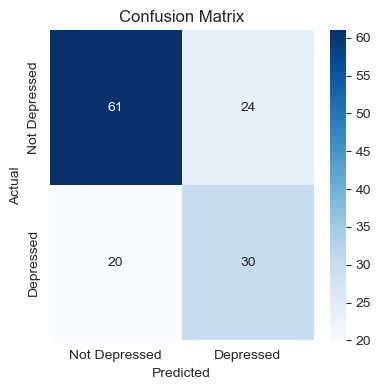

In [2312]:
def plot_confusion_matrix(cm, class_names=None, figsize=(4,4), cmap="Blues"):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

class_names = ['Not Depressed', 'Depressed']
plot_confusion_matrix(cm_test, class_names)

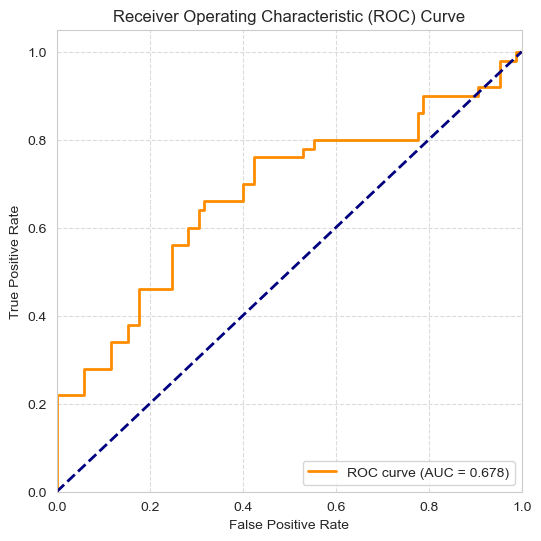

In [2313]:
allProbs = np.array(allProbs)
fpr, tpr, thresholds = roc_curve(allTrue, allProbs[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

An ROC/AUC of 67.8% indicates the model has moderate discriminative ability between depressed and non-depressed users.
- It correctly ranks positive cases higher than negative cases about two-thirds of the time, which is better than random (50%) but far from ideal.
- This suggests the model captures some meaningful patterns in temporal and contextual features, yet there is room for improvement.
- Misclassifications, particularly false negatives, could have practical implications, as some depressed users may go undetected.
- Enhancing personalization, adding richer context, or incorporating additional behavioral or temporal features could help improve the AUC closer to clinically useful levels.

1. Current Split (2018 test, 3-year training):
- Test Accuracy: 0.66
- F1-score: 0.68
- AUC: 0.678 (~67.8%)
- Confusion Matrix shows moderate false positives and false negatives.

2. Leave-One-Dataset-Out (Reorder) across four years: [https://github.com/UW-EXP/GLOBEM]
- Balanced Accuracy: 0.53–0.57
- ROC AUC: 0.55–0.57

**Insights:**
- The current single-year test set (2018) shows better performance (accuracy 0.66, AUC 0.678) than the Reorder leave-one-year-out strategy.
- The Reorder results are lower and more consistent across datasets (~0.54–0.57), indicating that when the model is tested on completely unseen yearly distributions, its generalization drops.
- This suggests temporal shift or distribution differences across years affect model performance. The 2018-only test set might be more similar to the training years, inflating performance metrics.

Overall, our model works reasonably well within familiar data but struggles to generalize across unseen years, highlighting the need for temporal robustness and possibly domain adaptation techniques.


In context, “leave-one-dataset-out” (LODO) generalization means:
- The dataset is divided into multiple subsets (here, each year of the GLOBEM dataset is treated as a separate “dataset”).
- During training, the model is trained on all years except one, and then tested on the left-out year.
- This is repeated for each year, so every year serves once as a completely unseen test set.

**Purpose:** It evaluates how well the model generalizes to entirely new distributions that were not seen during training. Unlike a random train-test split, this setup is stricter because temporal, behavioral, or environmental differences across years may affect performance.

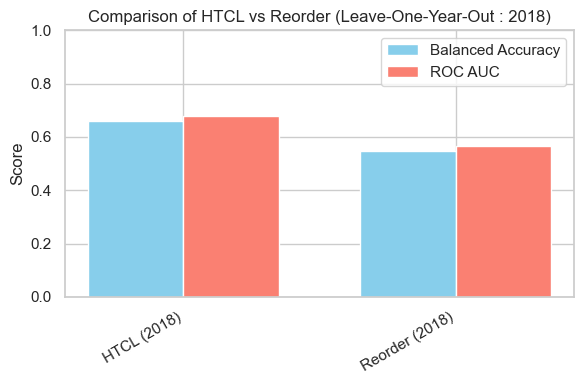

In [2318]:
# Prepare data
methods = ['HTCL (2018)', 'Reorder (2018)']
balanced_acc = [0.66, 0.548 ]
roc_auc = [0.678, 0.567]

df = pd.DataFrame({
    'Method': methods,
    'Balanced Accuracy': balanced_acc,
    'ROC AUC': roc_auc
})

# Set plot style
sns.set(style="whitegrid")
# Plot
fig, ax = plt.subplots(figsize=(6,4))
bar_width = 0.35
x = range(len(df))
ax.bar([i - bar_width/2 for i in x], df['Balanced Accuracy'], width=bar_width, label='Balanced Accuracy', color='skyblue')
ax.bar([i + bar_width/2 for i in x], df['ROC AUC'], width=bar_width, label='ROC AUC', color='salmon')
ax.set_xticks(x)
ax.set_xticklabels(df['Method'], rotation=30, ha='right')
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Comparison of HTCL vs Reorder (Leave-One-Year-Out : 2018)')
ax.legend()

plt.tight_layout()
plt.show()
